In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
#import seaborn as sns

In [2]:
df_weather = pd.read_csv('central_park_weather.csv', parse_dates=['DATE'])

In [3]:
df_weather = df_weather.loc[(df_weather.DATE >= pd.datetime(2017,1,1)) & (df_weather.DATE < pd.datetime(2017,7,1)), :]

In [4]:
# read data into pandas dataframe
df_nyiso = pd.read_csv('nyiso_2017.csv', parse_dates = ['time_stamp'])
df_nyc_taxi = pd.read_csv('nyc_taxi_2017.csv', parse_dates = ['time_stamp'])

In [5]:
df_nyiso.columns, df_nyc_taxi.columns, df_weather.columns

(Index([u'time_stamp', u'Integrated Load'], dtype='object'),
 Index([u'time_stamp', u'passenger_count'], dtype='object'),
 Index([u'DATE', u'AWND', u'PRCP', u'SNWD', u'TMIN', u'TMAX'], dtype='object'))

In [6]:
df_nyiso.shape, df_nyc_taxi.shape, df_weather.shape

((4343, 2), (4344, 2), (181, 6))

In [7]:
set(df_nyc_taxi.time_stamp.values) - set(df_nyiso.time_stamp.values)

{numpy.datetime64('2017-03-12T02:00:00.000000000')}

(736361.0, 736368.0)

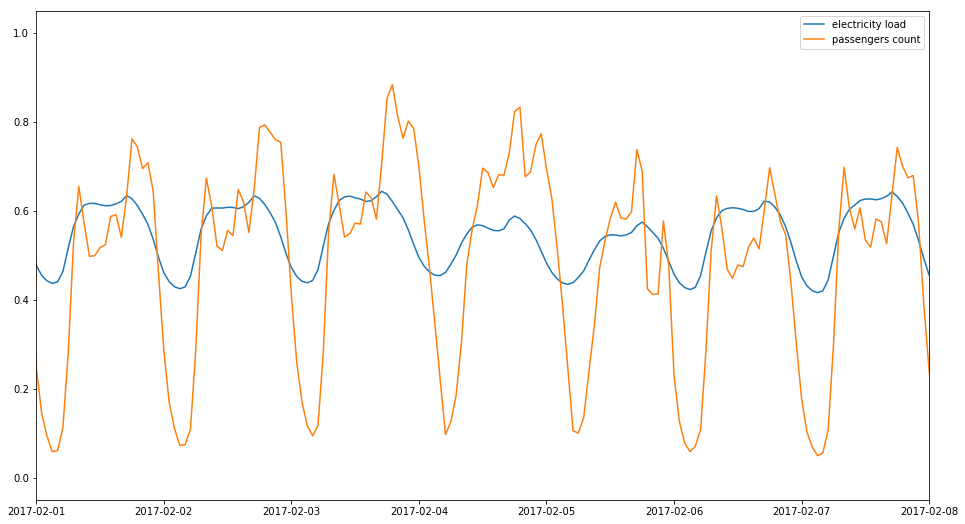

In [11]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_nyiso.iloc[:,0], df_nyiso.iloc[:,1]/max(df_nyiso.iloc[:,1]), label = 'electricity load')
ax.plot(df_nyc_taxi.iloc[:,0], df_nyc_taxi.iloc[:,1]/max(df_nyc_taxi.iloc[:,1]), label = 'passengers count')
#ax.plot(df_weather.iloc[:,0], df_weather.iloc[:,4]/max(df_weather.iloc[:,4]), label = 'tmin')
ax.legend()
ax.set_xlim(pd.datetime(2017,2,1), pd.datetime(2017,2,8))

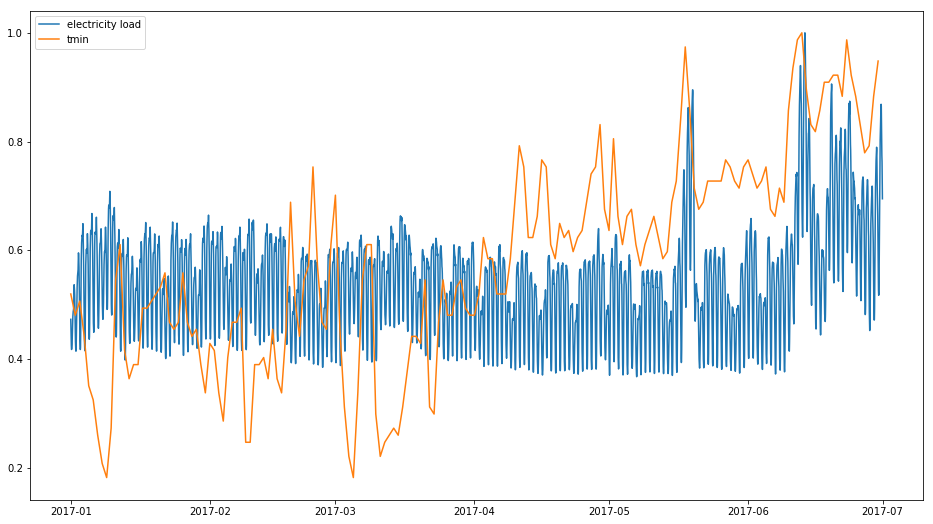

In [13]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_nyiso.iloc[:,0], df_nyiso.iloc[:,1]/max(df_nyiso.iloc[:,1]), label = 'electricity load')
#ax.plot(df_nyc_taxi.iloc[:,0], df_nyc_taxi.iloc[:,1]/max(df_nyc_taxi.iloc[:,1]), label = 'passengers count')
ax.plot(df_weather.iloc[:,0], df_weather.iloc[:,4]/max(df_weather.iloc[:,4]), label = 'tmin')
#ax.plot(df_weather.iloc[:,0], df_weather.iloc[:,5]/max(df_weather.iloc[:,5]), label = 'tmax')
#ax.plot(df_weather.iloc[:,0], df_weather.iloc[:,3]/max(df_weather.iloc[:,3]), label = 'tmin')
ax.legend()
#ax.set_xlim(pd.datetime(2017,6,3), pd.datetime(2017,6,4))

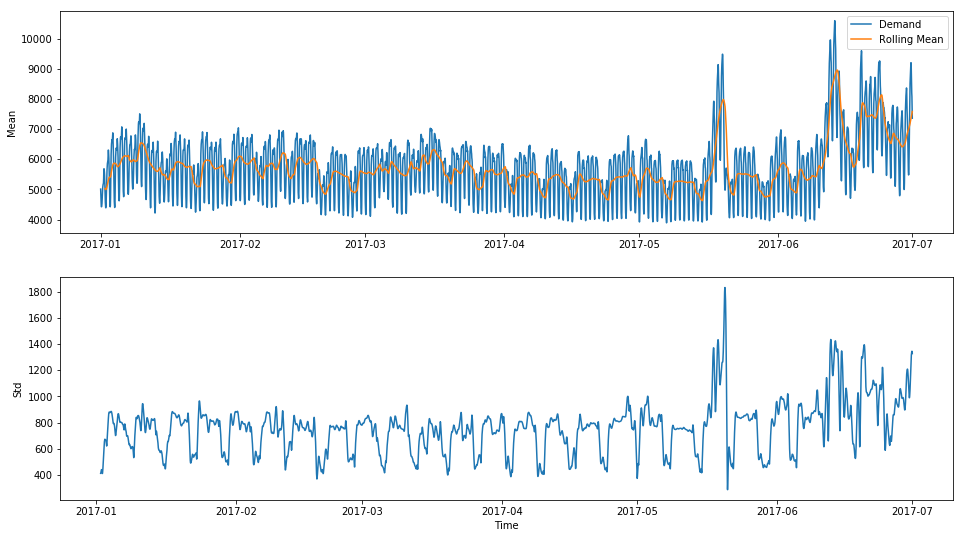

In [37]:
# calculate rolling mean: win = size of window to calculate over
win = 24
rollMean = df_nyiso.loc[:,'Integrated Load'].rolling(window=win, center=False).mean()
rollStd = df_nyiso.loc[:,'Integrated Load'].rolling(window=win, center=False).std()

# plot the rolling stats
fig, (ax1, ax2) = plt.subplots(2, figsize = (16, 9))
ax1.plot(df_nyiso.loc[:,'time_stamp'], df_nyiso.loc[:,'Integrated Load'], label='Demand')
ax1.plot(df_nyiso.loc[:,'time_stamp'], rollMean, label='Rolling Mean')
ax1.set_ylabel('Mean')
ax1.legend()
ax2.plot(df_nyiso.loc[:,'time_stamp'], rollStd, label='Rolling Std');
ax2.set_xlabel('Time');
ax2.set_ylabel('Std');


In [38]:
from statsmodels.tsa.stattools import adfuller

/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
dftest = adfuller(df_nyiso.loc[:,'Integrated Load'], autolag='AIC')

# the statsmodels output is ugly and unlabeled, lets use a function to format it nicely
def adf_output(dftest):
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])

    # the last element is a dictionary to unpack
    for key,value in dftest[4].items(): 
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
adf_output(dftest)

Test Statistic                   -5.070747
p-value                           0.000016
# of Lags Used                   28.000000
Number of Observations Used    4314.000000
Critical Value (5%)              -2.862210
Critical Value (1%)              -3.431867
Critical Value (10%)             -2.567127
dtype: float64


Here the p-value is smaller than 0.05, meaning that the data are stationary!

<a id='trend-removal'></a>
### Removing Trend to Make a Time Series Stationary

The simplest way to estimate and remove trend is to calculate a rolling mean and subtract it out:

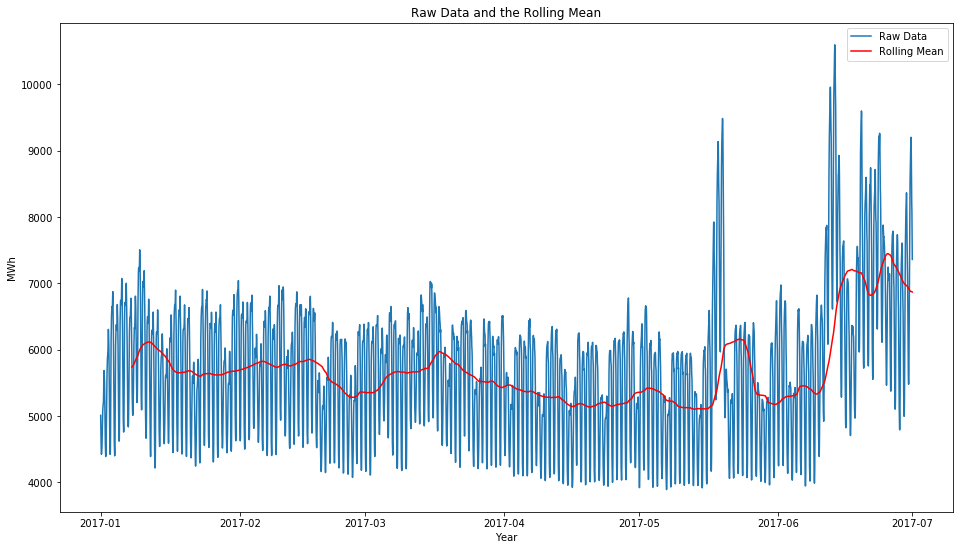

In [56]:
# calculate rolling mean
win = 24*7
rollMean = df_nyiso.loc[:,'Integrated Load'].rolling(window=win, center=False).mean()

# plot
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_nyiso.time_stamp, df_nyiso.loc[:,'Integrated Load'], label='Raw Data')
ax.plot(df_nyiso.time_stamp, rollMean, color='red', label='Rolling Mean')
ax.set_xlabel('Year');
ax.set_ylabel('MWh');
ax.legend()
ax.set_title("Raw Data and the Rolling Mean");

In [57]:
# subtract mean
demeaned = df_nyiso.loc[:,'Integrated Load'] - rollMean
demeaned.dropna(inplace=True)

# did this do anything for our stationarity?
demeaned_adf = adfuller(demeaned, autolag='AIC')
adf_output(demeaned_adf)

Test Statistic                -7.680568e+00
p-value                        1.507842e-11
# of Lags Used                 2.800000e+01
Number of Observations Used    4.147000e+03
Critical Value (5%)           -2.862237e+00
Critical Value (1%)           -3.431928e+00
Critical Value (10%)          -2.567141e+00
dtype: float64


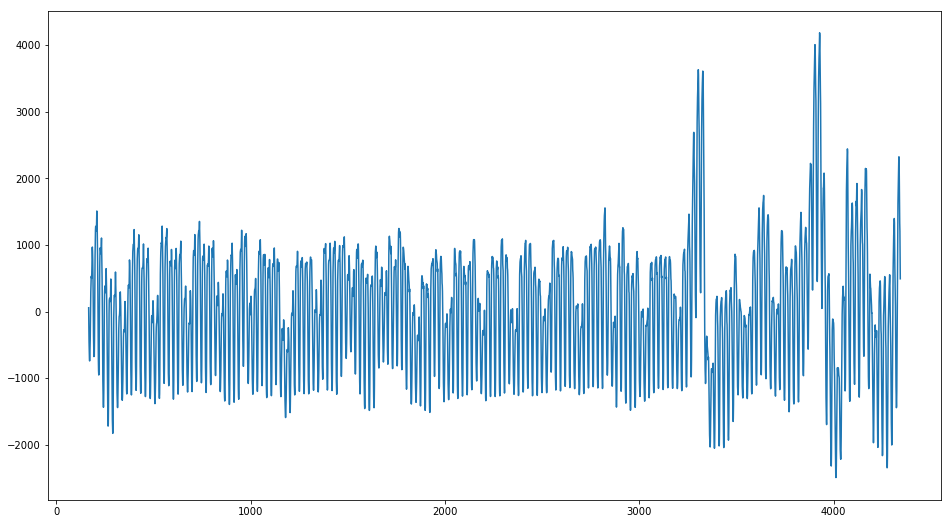

In [62]:
# plot the de-meaned time series
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(demeaned)

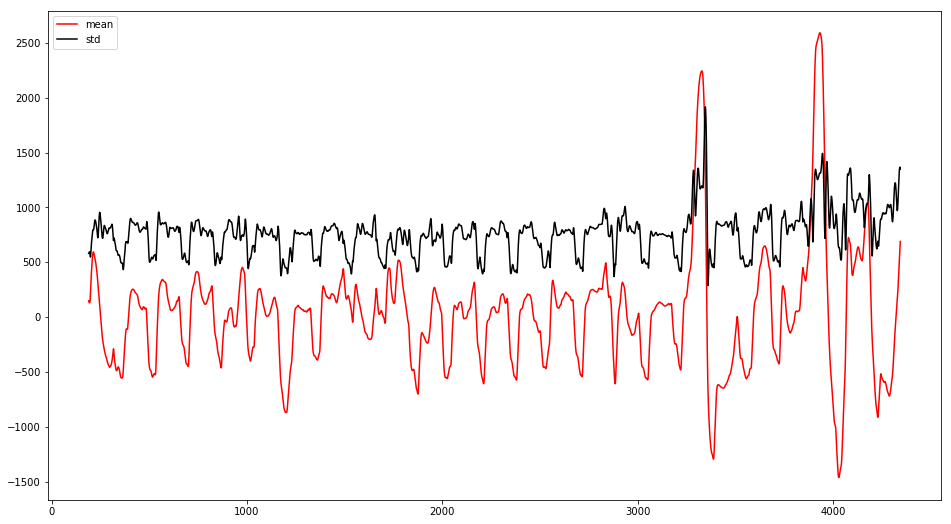

In [66]:
# rolling mean and std
win = 24
roll_demean = demeaned.rolling(window=win, center=False).mean()
roll_demean_std = demeaned.rolling(window=win, center=False).std()

# plot
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(roll_demean, color='red', label='mean')
ax.plot(roll_demean_std, color='black', label='std')
ax.legend(loc=2)

<a id='decomposition'></a>
### Decomposition - Modeling Trend and Season Separately

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [70]:
df_nyiso.set_index('time_stamp', inplace = True)

In [106]:
decomp = seasonal_decompose(df_nyiso.loc[:,'Integrated Load'], model="additive", freq=24*7)

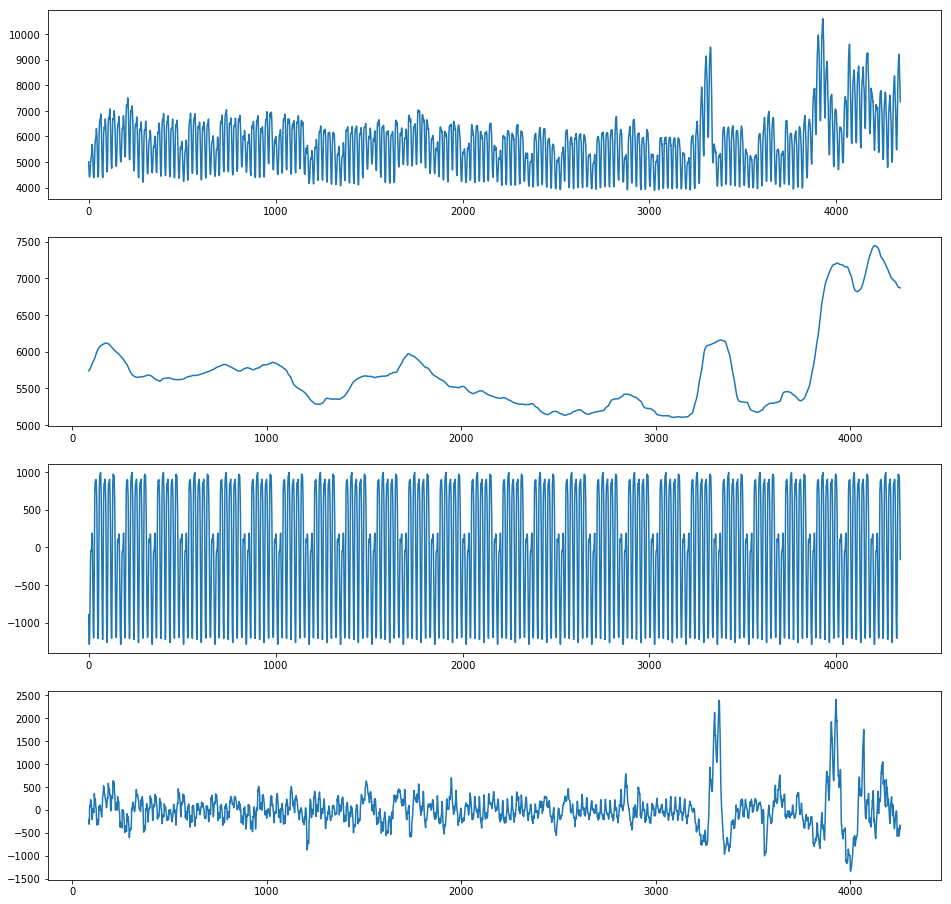

In [107]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (16, 16))
ax1.plot(df.index, df_nyiso.loc[:,'Integrated Load'])
ax2.plot(df.index, decomp.trend)
ax3.plot(df.index, decomp.seasonal)
ax4.plot(df.index, decomp.resid)

In [108]:
df_nyiso.index.values

array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ...,
       '2017-06-30T21:00:00.000000000', '2017-06-30T22:00:00.000000000',
       '2017-06-30T23:00:00.000000000'], dtype='datetime64[ns]')

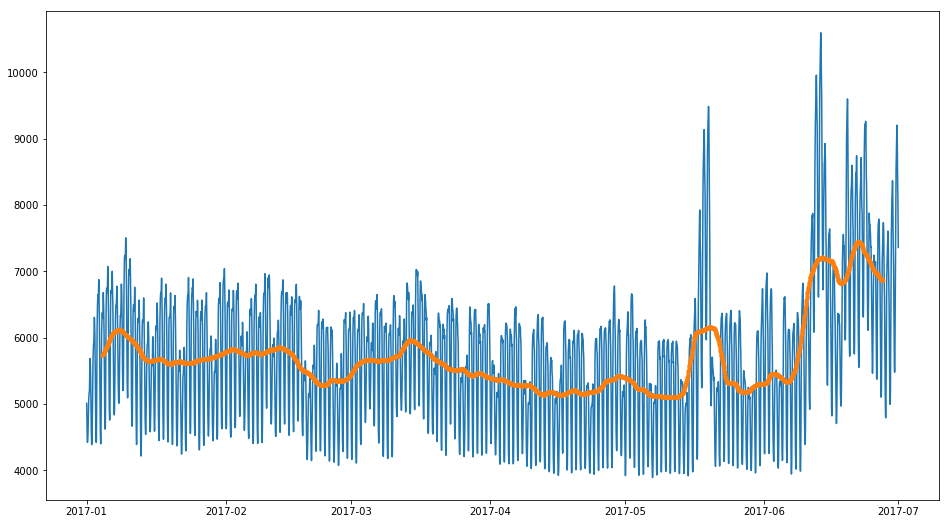

In [109]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_nyiso.index.values, df_nyiso.loc[:,'Integrated Load'])
ax.plot(df_nyiso.index.values, decomp.trend,'.')
#ax.set_xlim(pd.datetime(2017,7,14), pd.datetime(2017,7,20))
#plt.ylim(0, 2000)

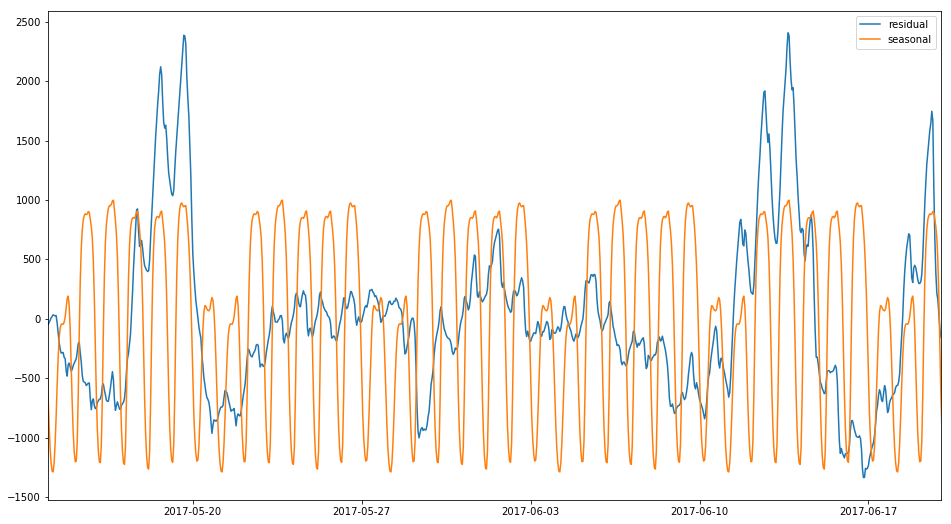

In [110]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(df_nyiso.index, decomp.resid, label = 'residual')
ax.plot(df_nyiso.index, decomp.seasonal, label = 'seasonal')
ax.set_xlim(pd.datetime(2017,5,14), pd.datetime(2017,6,20))
#plt.ylim(-5000, 5000)
plt.legend()

In [112]:
df_nyc_taxi.set_index('time_stamp', inplace = True)

In [116]:
temp_adf = adfuller(df_nyc_taxi.loc[:,'passenger_count'], autolag='AIC')
adf_output(temp_adf)

Test Statistic                -8.834149e+00
p-value                        1.737401e-14
# of Lags Used                 3.100000e+01
Number of Observations Used    4.312000e+03
Critical Value (5%)           -2.862211e+00
Critical Value (1%)           -3.431867e+00
Critical Value (10%)          -2.567127e+00
dtype: float64


In [117]:
from statsmodels.tsa.stattools import grangercausalitytests

In [118]:
# create a 2d dataframe to test if electricity load is caused by traffic
granger = pd.DataFrame({'load': df_nyiso.loc[:,'Integrated Load'], 'pass_count':df_nyc_taxi.loc[:,'passenger_count']})
granger = granger.dropna()

If you observe a p-value less than .05 for a given test, then the data are consistent with your second column Granger-causing the first column (or a lagged version of the second column Granger-causing the first). Here you see that the data are consistent with granger causality all the way back to a year.

In [124]:
granger_test = grangercausalitytests(granger, maxlag=24)


Granger Causality
('number of lags (no zero)', 1)
ssr based F test:         F=809.3114, p=0.0000  , df_denom=4339, df_num=1
ssr based chi2 test:   chi2=809.8709, p=0.0000  , df=1
likelihood ratio test: chi2=742.5900, p=0.0000  , df=1
parameter F test:         F=809.3114, p=0.0000  , df_denom=4339, df_num=1

Granger Causality
('number of lags (no zero)', 2)
ssr based F test:         F=783.3470, p=0.0000  , df_denom=4336, df_num=2
ssr based chi2 test:   chi2=1568.5005, p=0.0000  , df=2
likelihood ratio test: chi2=1339.0100, p=0.0000  , df=2
parameter F test:         F=783.3470, p=0.0000  , df_denom=4336, df_num=2

Granger Causality
('number of lags (no zero)', 3)
ssr based F test:         F=334.0164, p=0.0000  , df_denom=4333, df_num=3
ssr based chi2 test:   chi2=1003.6679, p=0.0000  , df=3
likelihood ratio test: chi2=902.8847, p=0.0000  , df=3
parameter F test:         F=334.0164, p=0.0000  , df_denom=4333, df_num=3

Granger Causality
('number of lags (no zero)', 4)
ssr based F test:  